In [1]:
import torch, torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.io.image import ImageReadMode

import imutils
import cv2
from PIL import Image
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt

In [2]:
print("torch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())

torch version:  1.8.1+cu101
cuda available:  True


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "gdrive/My Drive/Colab Notebooks/data/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/data


In [4]:
file_path = r"/content/gdrive/MyDrive/Colab Notebooks/data/denoising-data.zip"
extract_path = r"/content/sample_data/data"

''' Reads zip file from Gdrive and unpacks'''
shutil.unpack_archive(filename = file_path, extract_dir = extract_path)

**helper functions**

In [5]:
def save_decoded_image(img, name):
  img = img.view(img.size(0), img.size(1), img.size(2), img.size(3))
  save_image(img, name)

# visualize train images
def show_image(path):
    plt.figure(figsize=(10, 7))
    img = cv2.imread(path, 0)
    print("image dimensions: ", img.shape)
    plt.imshow(img, cmap='gray')
    plt.show()

def unnormalize_img_data(p_img_tensor):
  return (p_img_tensor.squeeze(0).numpy() * 255).astype(np.uint8)

**Define global file paths**

In [6]:
train_path_noisy = r"/content/sample_data/data/denoising-data/input/train/"
train_path_clean = r"/content/sample_data/data/denoising-data/input/train_cleaned/"
test_path = r"/content/sample_data/data/denoising-data/input/test/"
save_img_path = r"/content/sample_data/data/denoising-data/output/saved_images/"

img_names = glob.os.listdir(train_path_noisy)

train_noisy_imgs_path = glob.glob(train_path_noisy + "*.png")
train_clean_imgs_path = glob.glob(train_path_clean + "*.png")
test_imgs_path = glob.glob(test_path + "*.png")

**View Original noisy & clean images**

image dimensions:  (258, 540)


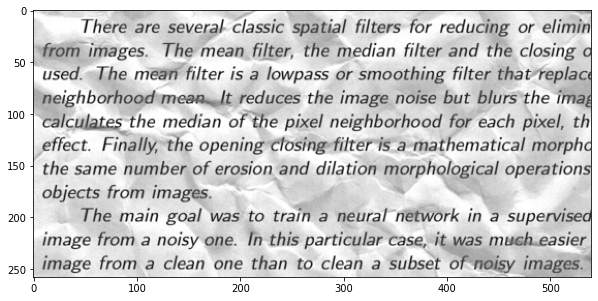

image dimensions:  (258, 540)


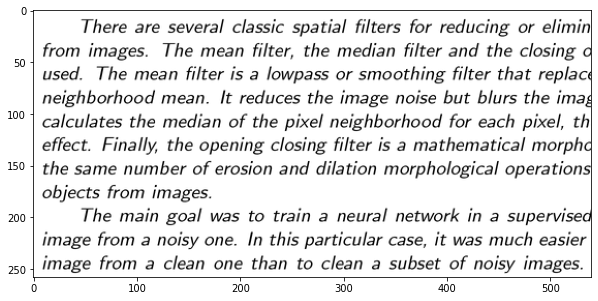

In [7]:
img_name = img_names[np.random.randint(0, len(img_names))]
show_image(train_path_noisy + img_name)
show_image(train_path_clean + img_name)

**Create Random crops pairs (source & target image)**

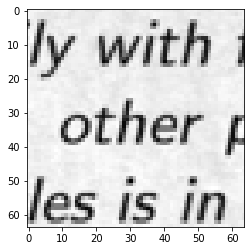

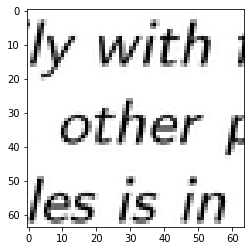

In [8]:
def get_random_crop(crop_size, src_path, trg_path = None):

  src_img = cv2.imread(src_path, 0)
  target_img = None if trg_path is None else cv2.imread(trg_path)

  ''' randomly resize the images '''
  if np.random.rand() > 0.5:

    max_width, min_width = (src_img.shape[1], 300) if src_img.shape[1] >= 300 else \
                            (src_img.shape[1], src_img.shape[1] - 100)

    random_width = np.random.randint(min_width, max_width)
    src_img = imutils.resize(src_img, width=random_width, inter=cv2.INTER_CUBIC)
    print("img resized to width : ", random_width)

    if trg_path != None:
      target_img = imutils.resize(target_img, width=random_width, inter=cv2.INTER_CUBIC)

  h, w = src_img.shape[0], src_img.shape[1]
  r = np.random.randint(0, h - crop_size)
  c = np.random.randint(0, w - crop_size)

  return (src_img[r:r+crop_size, c:c+crop_size], \
          None if trg_path is None else target_img[r:r+crop_size, c:c+crop_size])

''' Perform random resize/crop & generate src/target image pair'''
crop_size = 64
r_idx = np.random.randint(0, len(train_noisy_imgs_path))
noisy_crop, trg_crop = get_random_crop(crop_size, train_noisy_imgs_path[r_idx], \
                                       train_clean_imgs_path[r_idx])

plt.imshow(noisy_crop, cmap='gray')
plt.show()
plt.imshow(trg_crop, cmap='gray')
plt.show()

**Create Dataset & Loaders**

In [9]:
class CustomPairDataset(Dataset):
    def __init__(self, p_img_path_list, p_crop_size, train=True):

        self.train_mode = train
        self.src_img_paths = self.target_img_paths = None
        self.crop_size = p_crop_size

        if train:
          self.src_img_paths, self.target_img_paths = p_img_path_list[0], p_img_path_list[1]
        else:
          self.src_img_paths = p_img_path_list[0]

    def __len__(self):
        return len(self.src_img_paths)

    def get_random_crop(self, src_path, trg_path = None):

        src_img = cv2.imread(src_path, 0)
        target_img = None if trg_path is None else cv2.imread(trg_path, 0)

        ''' randomly resize the images, use imutils to maintain aspect ratio'''

        if np.random.rand() > 0.5:
          max_width, min_width = (src_img.shape[1], 300) if src_img.shape[1] >= 300 else \
                                  (src_img.shape[1], src_img.shape[1] - 50)

          random_width = np.random.randint(min_width, max_width)
          src_img = imutils.resize(src_img, width=random_width, inter=cv2.INTER_CUBIC)
          if trg_path != None:
            target_img = imutils.resize(target_img, width=random_width, inter=cv2.INTER_CUBIC)

        h, w = src_img.shape[0], src_img.shape[1]
        r = np.random.randint(0, h - self.crop_size)
        c = np.random.randint(0, w - self.crop_size)
        
        src_crop = src_img[r:r+self.crop_size, c:c+self.crop_size]
        trg_crop = None if trg_path is None else target_img[r:r+self.crop_size, c:c+self.crop_size]
        
        return (src_crop, trg_crop)

    def __getitem__(self, idx):

        trg_img_path = None
        src_img_path = self.src_img_paths[idx]
        
        if self.train_mode:
          trg_img_path = self.target_img_paths[idx]

        src_crop, trg_crop = self.get_random_crop(src_img_path, trg_img_path)

        if self.train_mode:
          src_crop = torch.tensor(src_crop).unsqueeze(0)/255.0
          trg_crop = torch.tensor(trg_crop).unsqueeze(0)/255.0
          return (src_crop, trg_crop)
        else:
          src_crop = torch.tensor(src_crop).unsqueeze(0)/255.0
          return src_crop


# Define Global constants
num_epochs = 1500
learning_rate = 1e-3
train_batch_size = 32
test_batch_size = 2
crop_size = 64

device = torch.device("cuda") if torch.cuda.is_available() \
                              else torch.device("cpu") 

''' Create train & test data loader'''
train_dataloader = DataLoader(CustomPairDataset([train_noisy_imgs_path, \
                                                 train_clean_imgs_path], \
                                                crop_size, train=True), \
                              batch_size=train_batch_size, shuffle=True)

test_dataloader = DataLoader(CustomPairDataset([test_imgs_path], crop_size, train= False), \
                             batch_size=test_batch_size, shuffle=True)

**Test the loaders**

src shape:  torch.Size([1, 64, 64])
trg_imgs:  torch.Size([1, 64, 64])


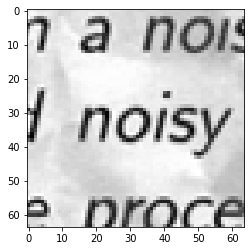

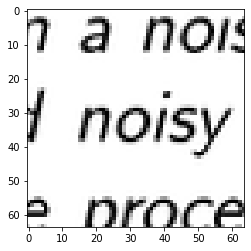

In [10]:
for img_pair in train_dataloader:
  src_imgs = img_pair[0]
  trg_imgs = img_pair[1]
  print("src shape: ", src_imgs[0].size())
  print("trg_imgs: ", trg_imgs[0].size())
  break

plt.imshow(unnormalize_img_data(src_imgs[0]), cmap='gray')
plt.show()
plt.imshow(unnormalize_img_data(trg_imgs[0]), cmap='gray')
plt.show()

**Model Architecture**
[Borrowed model arch from below link](https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjY5ZWQ1N2Y0MjQ0OTEyODJhMTgwMjBmZDU4NTk1NGI3MGJiNDVhZTAiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2MjAzNzYzMTQsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjExNTc2MTQ2MTc0OTQxNjk3NTQ1MyIsImVtYWlsIjoiYmhhcmF0aC5wYXR1cmlAZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImF6cCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsIm5hbWUiOiJCaGFyYXRoIFBhdHVyaSIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS0vQU9oMTRHZ2p2bTJRWWRObW9MMmFKQ19RWF9SOEZDV0dONW1hb3UzVERfVWZRdz1zOTYtYyIsImdpdmVuX25hbWUiOiJCaGFyYXRoIiwiZmFtaWx5X25hbWUiOiJQYXR1cmkiLCJpYXQiOjE2MjAzNzY2MTQsImV4cCI6MTYyMDM4MDIxNCwianRpIjoiZjJmZjM5MzE2MDI3NTE3Y2QzMDVjN2RjNzdjYzgxZTVmZjVjMTFjMiJ9.CIn6vVc8x_8h7uh6Y6e9IjKso7HlmKTP9duTaZLhIlsNbX9ewxQeGKUDtUYTk3c6fXkWnJa2G6Fa3gNJS2PYS8kTK5MACJTcTo6V-bJRm2Koesehx3FdFp94mG-bATf-dy0fDSDC8B5AFoJZb0pB7tqrsyAkAWqS4ocT3yz9sweqN7wMMXhaIe8e6Aeutd81meHgPQcj-Thkpivvo9i4LajwSqGhvVghdvfDRtAORgUUV3PXxwiu5iBd-x28ymvpNU4IMeZw9nH8iV318JR9nxh_2GXlfXtYGC9rwqeWOos3-crpytXacQqlnA4dsmQsFSMEC8a2hHcw-4LFlPlajg)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels, out_channels, latent_dim):
        super(Autoencoder, self).__init__()

        self.z_dim = latent_dim
        self.conv1 = self.contract_block(in_channels, 16, 7, 3)
        self.conv2 = self.contract_block(16, 32, 3, 1)
        self.conv3 = self.contract_block(32, 64, 3, 1)
        self.conv4 = self.contract_block(64, 128, 3, 1)

        self.upconv4 = self.expand_block(128, 64, 3, 1)
        self.upconv3 = self.expand_block(64*2, 32, 3, 1)
        self.upconv2 = self.expand_block(32*2, 16, 3, 1)
        self.upconv1 = self.expand_block(16*2, out_channels, 3, 1)

        # 2048 is the tensor size after flattening the encoded feature map.
        # 2048 is for a crop size of 64. Need to change based on the crop size.

        img_dim = 128 * 4 * 4
        self.reshape_dim = (-1, 128, 4, 4)
        self.encoder_fc = nn.Linear(img_dim, self.z_dim * 2)
        self.decoder_fc = nn.Linear(self.z_dim, img_dim)

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(
          torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
          torch.nn.BatchNorm2d(out_channels),
          torch.nn.ReLU(),
          torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
          torch.nn.BatchNorm2d(out_channels),
          torch.nn.ReLU(),
          torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, \
                                   stride=2, padding=1, output_padding=1)
          )
        return expand
    
    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        return contract

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample

    def forward(self, x):
        # Encode
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        ''' This shape should be the img dimension'''
        #print("Shape of bottom encoded feature maps: ", conv4.size())
        encoder_out = self.encoder_fc(torch.flatten(conv4, start_dim=1)).view(-1, 2, self.z_dim)

        # the first feature values as mean
        mu = encoder_out[:, 0, :] 
        # the second feature values as variance
        log_var = encoder_out[:, 1, :]
        z = self.reparameterize(mu, log_var)

        dec_out = F.relu(self.decoder_fc(z))
        conv4 = dec_out.reshape(self.reshape_dim)

        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return torch.sigmoid(upconv1), mu, log_var

**Model Testing**

In [12]:
net = Autoencoder(in_channels=1, out_channels=1, latent_dim=1024)

test_input = torch.randn((16, 1, 64, 64))
out, _, _ = net(test_input)
print("input size: ", test_input.size())
print("out size: ", out.size())

print("input dim: ", 64 * 64)
print("encoded feature maps dim: ", 128 * 4 * 4)

input size:  torch.Size([16, 1, 64, 64])
out size:  torch.Size([16, 1, 64, 64])
input dim:  4096
encoded feature maps dim:  2048


**train/valid methods**

In [13]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(model, loader, optimizer, criterion, num_epochs, p_save_path):

    model.train()
    train_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0

        for img_pair in loader:
            img = img_pair[0]
            labels = img_pair[1]

            img = img.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs, mu, logvar = model(img)
            
            bce_loss = criterion(outputs, labels)
            loss = final_loss(bce_loss, mu, logvar)
            # backpropagation
            loss.backward()
            # update the parameters
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(loader)
        train_loss.append(epoch_loss)
        #print(f'Epoch {epoch+1} of {num_epochs}, Train Loss: {epoch_loss:.5f}')
        
        if epoch % 20 == 0:
          print(f'Epoch {epoch+1} of {num_epochs}, \
                Train Loss: {epoch_loss:.5f}')
          img_name = p_save_path + "denoised{}.png".format(epoch)
          save_decoded_image(outputs.cpu().data, name=img_name)

    return model, train_loss

def test(model, loader, p_save_path):
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(loader):
            img = data
            img = img.to(device)
            outputs, _, _ = model(img)
            img_name = p_save_path + "test_img{}.png".format(i)
            save_decoded_image(outputs.cpu().data, name=img_name)

**Model training**

In [14]:
net = Autoencoder(in_channels=1, out_channels=1, latent_dim=1024)
net.to(device)

criterion = nn.BCELoss(reduction='sum')
#criterion = nn.MSELoss(reduction='mean')

# the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
''' Train the model'''
net, train_loss = train(net, train_dataloader, optimizer, criterion, num_epochs, save_img_path)
print("final train loss: ", train_loss[-1])

Epoch 1 of 1500,                 Train Loss: 101840.77969
Epoch 21 of 1500,                 Train Loss: 70056.57266
Epoch 41 of 1500,                 Train Loss: 60232.27969
Epoch 61 of 1500,                 Train Loss: 48478.00625
Epoch 81 of 1500,                 Train Loss: 40317.45977
Epoch 101 of 1500,                 Train Loss: 35377.91641
Epoch 121 of 1500,                 Train Loss: 32090.59570
Epoch 141 of 1500,                 Train Loss: 30362.33945
Epoch 161 of 1500,                 Train Loss: 28512.24004
Epoch 181 of 1500,                 Train Loss: 27347.78242
Epoch 201 of 1500,                 Train Loss: 26879.84570
Epoch 221 of 1500,                 Train Loss: 26292.43496
Epoch 241 of 1500,                 Train Loss: 25985.35762
Epoch 261 of 1500,                 Train Loss: 25306.91602
Epoch 281 of 1500,                 Train Loss: 25017.65098
Epoch 301 of 1500,                 Train Loss: 25095.93867
Epoch 321 of 1500,                 Train Loss: 24717.73203
Ep

**Inference on train data**

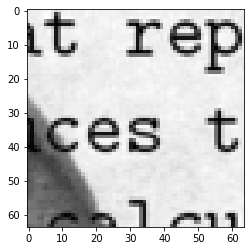

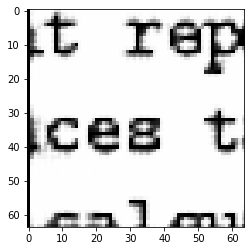

In [20]:
''' put in eval mode to disable batchnorm '''
net.eval()
with torch.no_grad():
  for test_img in (train_dataloader):
      img = test_img[0].to(device)
      outputs, _, _ = net(img)
      
      plt.imshow(unnormalize_img_data(img[0].cpu()), cmap='gray')
      plt.show()
      plt.imshow(unnormalize_img_data(outputs[0].cpu()), \
                 cmap='gray')
      plt.show()
      break

**inference on test set**

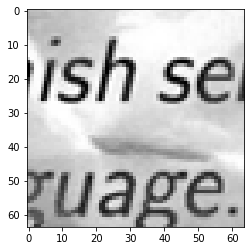

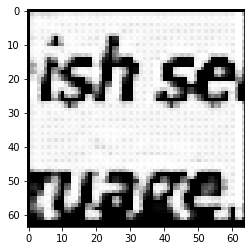

In [23]:
# with torch.no_grad():
#   for test_img in (test_dataloader):
#       test_img = test_img.to(device)
#       outputs = net(test_img)
      
#       plt.imshow(unnormalize_img_data(test_img[0].cpu()), cmap='gray')
#       plt.show()
#       plt.imshow(unnormalize_img_data(outputs[0].cpu()), cmap='gray')
#       plt.show()
#       break